In [452]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
from glob import glob
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import resample
from librosa.core import stft
from librosa.core import amplitude_to_db
from librosa.display import specshow
from functools import partial

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Chapter 1 - Time Series and Machine Learning Primer

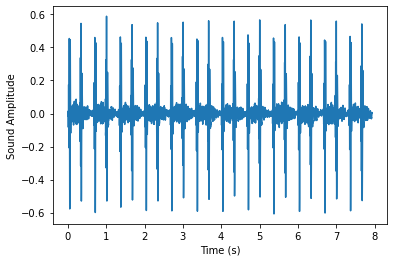

In [2]:
data_dir = './heartbeat_data/set_a'

# List all the wav files in the folder
audio_files = glob(data_dir + '/*.wav')

# MATCH DATACAMP FILE
audio_files[0] = data_dir + '/murmur__201108222238.wav'
# Read in the first audio file, create the time array
audio, sfreq = lr.load(audio_files[0])
time = np.arange(0, len(audio)) / sfreq

# Plot audio over time
fig, ax = plt.subplots()
ax.plot(time, audio)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()

In [3]:
# Read in the data
data = pd.read_csv('prices.csv', index_col=0)
# Convert the index of the DataFrame to datetime
data.index = pd.to_datetime(data.index)
data = data[data.symbol.isin(['AAPL', 'FB', 'NFLX', 'V', 'XOM'])]
data = data.pivot(columns='symbol', values=['close'])
data.columns = [tup[1] for tup in data.columns.to_flat_index()]
data.head()

,AAPL,FB,NFLX,V,XOM
date,,,,,
2010-01-04,214.009998,NaN,53.479999,88.139999,69.150002
2010-01-05,214.379993,NaN,51.510001,87.129997,69.419998
2010-01-06,210.969995,NaN,53.319999,85.959999,70.019997
2010-01-07,210.580000,NaN,52.400001,86.760002,69.800003
2010-01-08,211.980005,NaN,53.300002,87.000000,69.519997


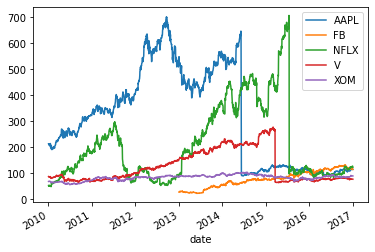

In [4]:
# Loop through each column, plot its values over time
fig, ax = plt.subplots()
for column in data:
    data[column].plot(ax=ax, label=column)
ax.legend()
plt.show()

# Chapter 2 - Time Series as Inputs to a Model

In [5]:
normal = pd.read_csv('normal.csv', index_col='time')
normal.head()

,3,4,6
time,,,
0.000000,-0.000995,0.000281,0.002953
0.000454,-0.003381,0.000381,0.003034
0.000907,-0.000948,0.000063,0.000292
0.001361,-0.000766,0.000026,-0.005916
0.001814,0.000469,-0.000432,-0.005307


In [6]:
abnormal = pd.read_csv('abnormal.csv', index_col='time')
abnormal.head()

,0,1,2
time,,,
0.000000,-0.024684,-0.024507,0.008254
0.000454,-0.060429,-0.047736,0.014809
0.000907,-0.070080,-0.039938,0.010475
0.001361,-0.084212,-0.041199,0.010272
0.001814,-0.085111,-0.036050,0.008580


In [7]:
def show_plot_and_make_titles():
    axs[0, 0].set(title="Normal Heartbeats")
    axs[0, 1].set(title="Abnormal Heartbeats")
    plt.tight_layout()
    plt.show()

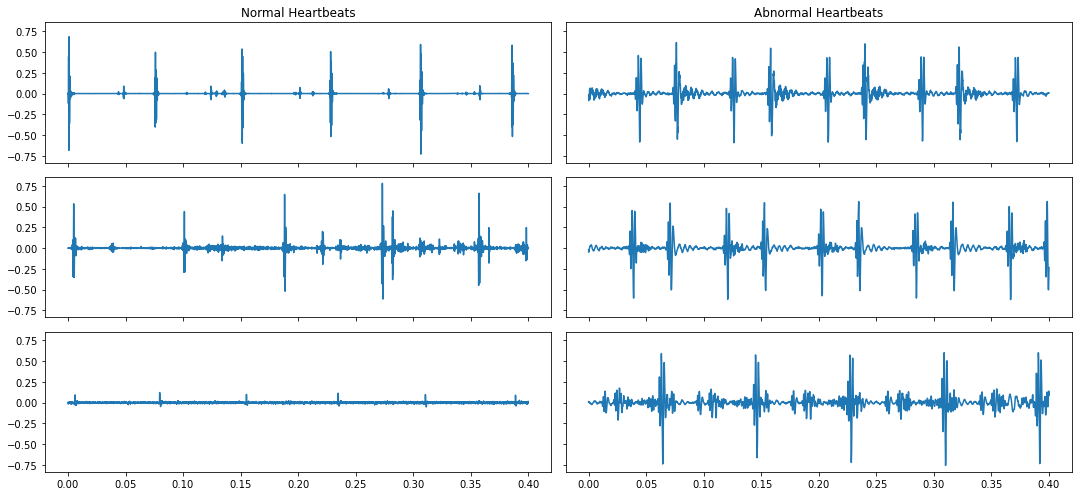

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(15, 7), sharex=True, sharey=True)

# Calculate the time array
time = np.arange(normal.shape[0]) / sfreq

# Stack the normal/abnormal audio so you can loop and plot
stacked_audio = np.hstack([normal, abnormal]).T

# Loop through each audio file / ax object and plot
# .T.ravel() transposes the array, then unravels it into a 1-D vector for looping
for iaudio, ax in zip(stacked_audio, axs.T.ravel()):
    ax.plot(time, iaudio)
show_plot_and_make_titles()

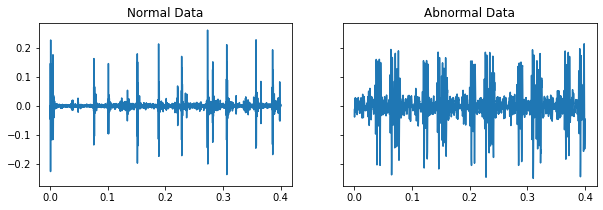

In [9]:
# Average across the audio files of each DataFrame
mean_normal = np.mean(normal, axis=1)
mean_abnormal = np.mean(abnormal, axis=1)

# Plot each average over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax1.plot(time, mean_normal)
ax1.set(title="Normal Data")
ax2.plot(time, mean_abnormal)
ax2.set(title="Abnormal Data")
plt.show()

In [10]:
pd.DataFrame(stacked_audio)

,0,1,2,3,4,5,6,7,8,9,...,8810,8811,8812,8813,8814,8815,8816,8817,8818,8819
0,-0.000995,-0.003381,-0.000948,-0.000766,0.000469,0.001511,0.007789,-0.000887,-0.091828,-0.120524,...,-0.000034,0.000034,0.000192,0.000552,0.000232,-0.000089,-0.000112,-0.000233,-0.000103,-0.000367
1,0.000281,0.000381,0.000063,0.000026,-0.000432,0.000075,-0.001401,-0.002424,-0.002455,-0.003432,...,-0.007169,-0.010088,-0.006626,-0.004099,-0.002884,-0.005931,-0.004839,-0.000591,-0.001320,0.000652
2,0.002953,0.003034,0.000292,-0.005916,-0.005307,-0.003470,-0.010840,-0.010687,-0.016578,-0.014512,...,-0.001623,0.001349,-0.002345,-0.001517,0.004005,0.002474,0.004467,0.016809,0.008762,0.004442
3,-0.024684,-0.060429,-0.070080,-0.084212,-0.085111,-0.078485,-0.059435,-0.037479,-0.018771,-0.010869,...,0.005545,0.006911,0.008975,0.010534,0.010939,0.010513,0.009675,0.007957,0.006445,0.006529
4,-0.024507,-0.047736,-0.039938,-0.041199,-0.036050,-0.034257,-0.029402,-0.026873,-0.024032,-0.022241,...,-0.501343,-0.496709,-0.485694,-0.466190,-0.437779,-0.401539,-0.360107,-0.317170,-0.275164,-0.233864
5,0.008254,0.014809,0.010475,0.010272,0.008580,0.008634,0.007643,0.008110,0.008904,0.009059,...,0.087628,0.103080,0.117393,0.128866,0.136350,0.138510,0.134382,0.124178,0.109530,0.090629


## Model and Predict Time Series

In [11]:
def load_data(label):
    if label == 'normal':
        data_dir = './heartbeat_data/set_a/normal'
    else:
        data_dir = './heartbeat_data/set_a/murmur'        

    # List all the wav files in the folder
    audio_files = glob(data_dir + '*.wav')
    
    # Create DataFrame
    df = pd.DataFrame(columns=np.arange(0,8820))
    
    # Load DataFrame
    for f in audio_files:
        # Read in the first audio file, create the time array
        audio, sfreq = lr.load(f)
        time = np.arange(0, len(audio)) / sfreq

        # Trim down to 8820 time slices
        audio = audio[:8820]
        time = time[:8820]

        # Append DataFrame
        df = pd.concat([df, pd.DataFrame(audio).T], axis=0, ignore_index=True)

    df['label'] = label
    return df

In [12]:
df_normal = load_data('normal')
df_abnormal = load_data('abnormal')
df = pd.concat([df_normal, df_abnormal], axis=0, ignore_index=True)
print(df.shape)
df.head()

(65, 8821)


,0,1,2,3,4,5,6,7,8,9,...,8811,8812,8813,8814,8815,8816,8817,8818,8819,label
0,0.000372,0.000374,0.000043,0.000183,0.000044,0.000322,0.00038,-0.000208,-0.000544,-0.000478,...,0.000861,0.000645,0.000108,0.000218,0.000544,0.00017,-0.000059,-0.000557,-0.000316,normal
1,0.03053,0.044925,0.03949,0.042998,0.040716,0.049382,0.049148,0.047897,0.045423,0.043086,...,0.15088,0.15032,0.147947,0.145572,0.144996,0.144822,0.143852,0.141795,0.139464,normal
2,0.003224,0.006052,0.003248,0.006324,0.004714,0.00342,0.005197,0.003082,0.005501,0.002675,...,-0.001801,-0.000911,-0.000257,0.002122,-0.002339,0.002217,0.000491,0.000844,0.002226,normal
3,0.006436,0.00851,0.004068,0.001876,-0.001555,-0.00489,-0.008182,-0.008108,-0.008993,-0.008604,...,0.008793,0.00789,0.006157,0.006671,0.008081,0.005449,0.003526,0.003555,0.002348,normal
4,0.000222,0.000273,-0.000385,-0.000176,-0.000049,0.000016,0.000198,0.000195,0.000304,-0.000493,...,0.000365,-0.000011,-0.000162,-0.000335,-0.000731,-0.000738,-0.000395,-0.000073,0.000067,normal


In [13]:
y = df.label
X = df.drop('label', axis=1)
X.shape, y.shape

((65, 8820), (65,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [15]:
# Initialize and fit the model
model = LinearSVC()
model.fit(X_train, y_train)

# Generate predictions and score them manually
predictions = model.predict(X_test)
print(sum(predictions == y_test.squeeze()) / len(y_test))

0.65


## Rectify and Smooth

In [33]:
data_dir = './heartbeat_data/set_a'

# List all the wav files in the folder
audio_files = glob(data_dir + '/*.wav')

# Read in the first audio file, create the time array
audio, sfreq = lr.load(audio_files[0])
time = np.arange(0, len(audio)) / sfreq

In [34]:
# Trim down to 8820 time slices
audio = audio[:8820]
time = time[:8820]

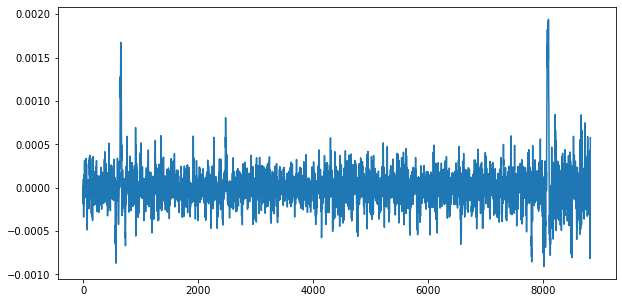

In [35]:
# Plot the raw data first
audio = pd.Series(audio)
audio.plot(figsize=(10, 5))
plt.show()

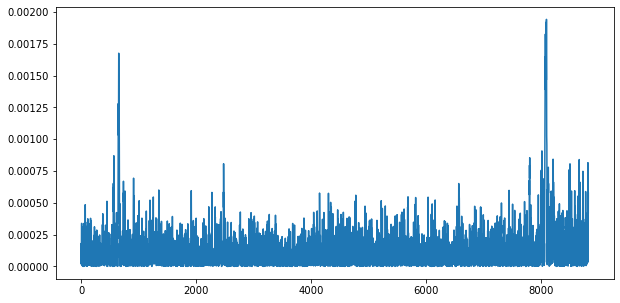

In [36]:
# Rectify the audio signal
audio_rectified = audio.apply(np.abs)

# Plot the result
audio_rectified.plot(figsize=(10, 5))
plt.show()

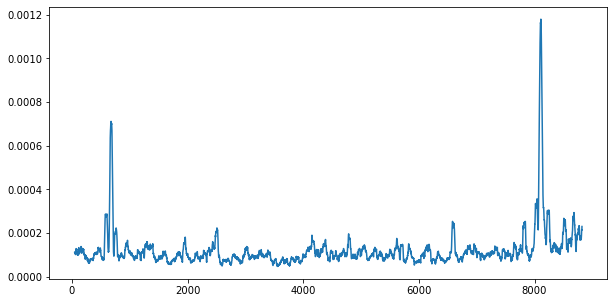

In [37]:
# Smooth by applying a rolling mean
audio_rectified_smooth = audio_rectified.rolling(50).mean()

# Plot the result
audio_rectified_smooth.plot(figsize=(10, 5))
plt.show()

## Engineer new features

In [49]:
def load_data_engineered(label):
    if label == 'normal':
        data_dir = './heartbeat_data/set_a/normal'
    else:
        data_dir = './heartbeat_data/set_a/murmur'        

    # List all the wav files in the folder
    audio_files = glob(data_dir + '*.wav')
    
    # Create DataFrame
    df = pd.DataFrame(columns=['means', 'stds', 'maxs'])
    
    # Load DataFrame
    for f in audio_files:
        # Read in the first audio file, create the time array
        audio, sfreq = lr.load(f)
        time = np.arange(0, len(audio)) / sfreq

        # Trim down to 8820 time slices
        audio = audio[:8820]
        time = time[:8820]
        
        # Rectify and Smooth
        audio = pd.Series(audio)
        audio_rectified = audio.apply(np.abs)
        audio_rectified_smooth = audio_rectified.rolling(50).mean() 
        
        # Calculate stats
        means = np.mean(audio_rectified_smooth, axis=0)
        stds = np.std(audio_rectified_smooth, axis=0)
        maxs = np.max(audio_rectified_smooth, axis=0)
        
        # Combine new features
        features = np.column_stack([means, stds, maxs])

        # Append DataFrame
        df = pd.concat([df, pd.DataFrame(features, columns=['means', 'stds', 'maxs'])], axis=0) #, ignore_index=True)

    df['label'] = label
    return df

In [50]:
df_normal_eng = load_data_engineered('normal')
df_abnormal_eng = load_data_engineered('abnormal')
df = pd.concat([df_normal_eng, df_abnormal_eng], axis=0, ignore_index=True)
print(df.shape)
df.head()

(65, 4)


,means,stds,maxs,label
0,0.001761,0.004352,0.039826,normal
1,0.032588,0.031157,0.179327,normal
2,0.005144,0.006587,0.08244,normal
3,0.010385,0.011217,0.094778,normal
4,0.00101,0.002242,0.015006,normal


In [51]:
y_eng = df.label
X_eng = df.drop('label', axis=1)
X_eng.shape, y_eng.shape

((65, 3), (65,))

In [54]:
# Fit the model and score on testing data
percent_score = cross_val_score(model, X_eng, y_eng, cv=5)
print(np.mean(percent_score))

0.6461538461538461


## librosa Tempo

In [56]:
df_normal = load_data('normal')
df_abnormal = load_data('abnormal')
df = pd.concat([df_normal, df_abnormal], axis=0, ignore_index=True)
print(df.shape)
df.head()

(65, 8821)


,0,1,2,3,4,5,6,7,8,9,...,8811,8812,8813,8814,8815,8816,8817,8818,8819,label
0,0.000372,0.000374,0.000043,0.000183,0.000044,0.000322,0.00038,-0.000208,-0.000544,-0.000478,...,0.000861,0.000645,0.000108,0.000218,0.000544,0.00017,-0.000059,-0.000557,-0.000316,normal
1,0.03053,0.044925,0.03949,0.042998,0.040716,0.049382,0.049148,0.047897,0.045423,0.043086,...,0.15088,0.15032,0.147947,0.145572,0.144996,0.144822,0.143852,0.141795,0.139464,normal
2,0.003224,0.006052,0.003248,0.006324,0.004714,0.00342,0.005197,0.003082,0.005501,0.002675,...,-0.001801,-0.000911,-0.000257,0.002122,-0.002339,0.002217,0.000491,0.000844,0.002226,normal
3,0.006436,0.00851,0.004068,0.001876,-0.001555,-0.00489,-0.008182,-0.008108,-0.008993,-0.008604,...,0.008793,0.00789,0.006157,0.006671,0.008081,0.005449,0.003526,0.003555,0.002348,normal
4,0.000222,0.000273,-0.000385,-0.000176,-0.000049,0.000016,0.000198,0.000195,0.000304,-0.000493,...,0.000365,-0.000011,-0.000162,-0.000335,-0.000731,-0.000738,-0.000395,-0.000073,0.000067,normal


In [65]:
audio = df.drop('label', axis=1).T
print(audio.shape)
audio = audio.apply(pd.to_numeric, errors = 'coerce')
audio.head()

(8820, 65)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0.000372,0.030530,0.003224,0.006436,0.000222,-0.010349,-0.000554,0.000525,-0.000053,0.000152,...,-0.006913,-0.185096,-0.031637,-0.000614,-0.013211,0.113057,-0.168317,0.004103,-0.102160,0.010673
1,0.000374,0.044925,0.006052,0.008510,0.000273,-0.015578,-0.000925,0.000365,0.000022,0.000045,...,-0.011213,-0.296707,-0.050700,-0.000937,-0.021293,0.181618,-0.270060,0.006612,-0.164134,0.017101
2,0.000043,0.039490,0.003248,0.004068,-0.000385,-0.014346,-0.000357,0.000415,-0.000021,-0.000105,...,-0.010705,-0.280282,-0.047796,-0.000852,-0.020425,0.172172,-0.255433,0.006415,-0.155556,0.016136
3,0.000183,0.042998,0.006324,0.001876,-0.000176,-0.015706,0.000178,0.000907,-0.000013,-0.000057,...,-0.011455,-0.299051,-0.050911,-0.000864,-0.022089,0.184313,-0.272905,0.006997,-0.166525,0.017117
4,0.000044,0.040716,0.004714,-0.001555,-0.000049,-0.014963,0.000268,0.000819,-0.000087,-0.000092,...,-0.010570,-0.273499,-0.046451,-0.000738,-0.020629,0.169395,-0.249984,0.006671,-0.153068,0.015494


In [69]:
# Calculate the tempo of the sounds
tempos = []
for col, i_audio in audio.items():
    tempos.append(lr.beat.tempo(i_audio.values, sr=sfreq, hop_length=2**6, aggregate=None))

# Convert the list to an array so you can manipulate it more easily
tempos = np.array(tempos)

# Calculate statistics of each tempo
tempos_mean = tempos.mean(axis=-1)
tempos_std = tempos.std(axis=-1)
tempos_max = tempos.max(axis=-1)

In [70]:
tempos_mean.shape


(65,)

In [71]:
X_eng.shape

(65, 3)

## Engineer Features with librosa Tempos

In [77]:
def load_data_librosa(label):
    if label == 'normal':
        data_dir = './heartbeat_data/set_a/normal'
    else:
        data_dir = './heartbeat_data/set_a/murmur'        

    # List all the wav files in the folder
    audio_files = glob(data_dir + '*.wav')
    
    # Create DataFrame
    df = pd.DataFrame(columns=['means', 'stds', 'maxs', 'tempos_means', 'tempos_stds', 'tempos_maxs'])
    
    # Load DataFrame
    for f in audio_files:
        # Read in the first audio file, create the time array
        audio, sfreq = lr.load(f)
        time = np.arange(0, len(audio)) / sfreq

        # Trim down to 8820 time slices
        audio = audio[:8820]
        time = time[:8820]
        
        # librosa Tempos
        tempos = lr.beat.tempo(audio, sr=sfreq, hop_length=2**6, aggregate=None)
        # Calculate statistics of each tempo
        tempos_mean = tempos.mean()
        tempos_std = tempos.std()
        tempos_max = tempos.max()        
        
        # Rectify and Smooth
        audio = pd.Series(audio)
        audio_rectified = audio.apply(np.abs)
        audio_rectified_smooth = audio_rectified.rolling(50).mean() 
        
        # Calculate stats
        means = np.mean(audio_rectified_smooth, axis=0)
        stds = np.std(audio_rectified_smooth, axis=0)
        maxs = np.max(audio_rectified_smooth, axis=0)
        
        # Combine new features
        features = np.column_stack([means, stds, maxs, tempos_mean, tempos_std, tempos_max])

        # Append DataFrame
        df = pd.concat([df, pd.DataFrame(features, columns=['means', 'stds', 'maxs', 'tempos_means', 'tempos_stds', 'tempos_maxs'])], axis=0)

    df['label'] = label
    return df

In [78]:
df_normal_librosa = load_data_librosa('normal')
df_abnormal_librosa = load_data_librosa('abnormal')
df = pd.concat([df_normal_librosa, df_abnormal_librosa], axis=0, ignore_index=True)
print(df.shape)
df.head()

(65, 7)


,means,stds,maxs,tempos_means,tempos_stds,tempos_maxs,label
0,0.001761,0.004352,0.039826,136.629098,0.795984,137.8125,normal
1,0.032588,0.031157,0.179327,137.227489,0.826826,138.737416,normal
2,0.005144,0.006587,0.08244,137.234016,0.820636,138.737416,normal
3,0.010385,0.011217,0.094778,137.505106,0.812776,138.737416,normal
4,0.00101,0.002242,0.015006,237.607759,0.0,237.607759,normal


In [80]:
y_lib= df.label
X_lib = df.drop('label', axis=1)
X_lib.shape, y_lib.shape

((65, 6), (65,))

In [81]:
# Fit the model and score on testing data
percent_score = cross_val_score(model, X_lib, y_lib, cv=5)
print(np.mean(percent_score))

0.5076923076923077


C:\Users\mkars\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\mkars\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\mkars\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\mkars\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\mkars\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## librosa Spectrograms

In [280]:
# audio_sample = audio[[0]].values.reshape(-1)
audio_sample = audio.iloc[:,5].values.astype('float32')
type(audio_sample), audio_sample.shape

(numpy.ndarray, (8820,))

In [281]:
# Prepare the STFT
HOP_LENGTH = 2**4
Nfft = 2**7
spec = stft(audio_sample, hop_length=HOP_LENGTH, n_fft=Nfft)
spec = spec.astype(np.float)

C:\Users\mkars\AppData\Local\Temp\ipykernel_11348\3752153543.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  spec = spec.astype(np.float)
C:\Users\mkars\AppData\Local\Temp\ipykernel_11348\3752153543.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  spec = spec.astype(np.float)


In [282]:
# Convert into decibels
spec_db = amplitude_to_db(spec)

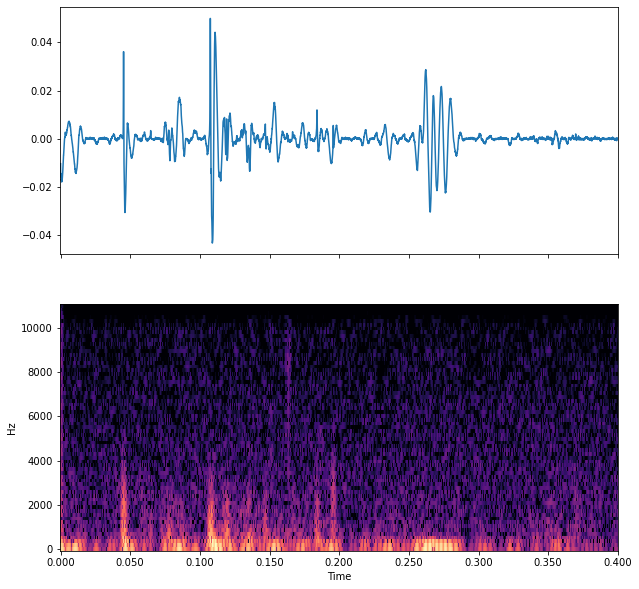

In [283]:
# Compare the raw audio to the spectrogram of the audio
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axs[0].plot(time, audio_sample)
specshow(spec_db, sr=sfreq, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH)
plt.show()

In [284]:
# Calculate the spectral centroid and bandwidth for the spectrogram
bandwidths = lr.feature.spectral_bandwidth(S=lr.db_to_amplitude(spec))[0]
centroids = lr.feature.spectral_centroid(S=lr.db_to_amplitude(spec))[0]

In [285]:
# times_spec = lr.fft_frequencies(sr=sfreq, n_fft=1102)
idx = np.round(np.linspace(0, len(time)-1, len(centroids))).astype(int)
times_spec = time[idx]

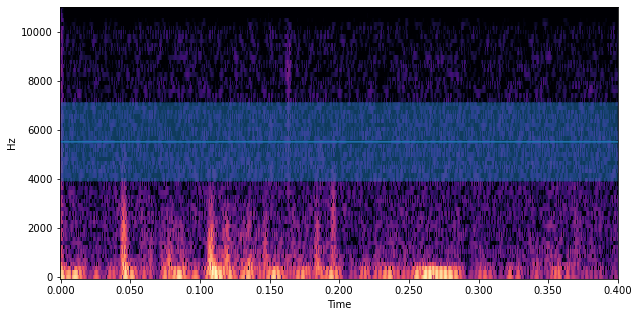

In [286]:
# Convert spectrogram to decibels for visualization
spec_db = amplitude_to_db(spec)

# Display these features on top of the spectrogram
fig, ax = plt.subplots(figsize=(10, 5))
specshow(spec_db, ax=ax, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH)
ax.set(ylim=[None, 11025])
ax.plot(times_spec, centroids)
ax.fill_between(times_spec, centroids - bandwidths / 2, centroids + bandwidths / 2, alpha=.5)
plt.show()

## Engineer Features with librosa Spectragram stft

In [295]:
def load_data_stft(label):
    if label == 'normal':
        data_dir = './heartbeat_data/set_a/normal'
    else:
        data_dir = './heartbeat_data/set_a/murmur'        

    # List all the wav files in the folder
    audio_files = glob(data_dir + '*.wav')
    
    # Create DataFrame
    df = pd.DataFrame(columns=['means', 'stds', 'maxs', 
                               'tempos_means', 'tempos_stds', 'tempos_maxs', 
                               'bandwidth_mean', 'centriod_mean'])
    
    # Load DataFrame
    for f in audio_files:
        # Read in the first audio file, create the time array
        audio, sfreq = lr.load(f)
        time = np.arange(0, len(audio)) / sfreq

        # Trim down to 8820 time slices
        audio = audio[:8820]
        time = time[:8820]
        
        # librosa Tempos
        tempos = lr.beat.tempo(audio, sr=sfreq, hop_length=2**6, aggregate=None)
        # Calculate statistics of each tempo
        tempos_mean = tempos.mean()
        tempos_std = tempos.std()
        tempos_max = tempos.max()  
        
        # Prepare the STFT
        HOP_LENGTH = 2**4
        Nfft = 2**7
        spec = stft(audio_sample, hop_length=HOP_LENGTH, n_fft=Nfft)
        spec = spec.astype(np.float64)
        bandwidth_mean = np.mean(lr.feature.spectral_bandwidth(S=lr.db_to_amplitude(spec)))
        centroid_mean = np.mean(lr.feature.spectral_centroid(S=lr.db_to_amplitude(spec)))
        
        # Rectify and Smooth
        audio = pd.Series(audio)
        audio_rectified = audio.apply(np.abs)
        audio_rectified_smooth = audio_rectified.rolling(50).mean() 
        
        # Calculate stats
        means = np.mean(audio_rectified_smooth, axis=0)
        stds = np.std(audio_rectified_smooth, axis=0)
        maxs = np.max(audio_rectified_smooth, axis=0)
        
        # Combine new features
        features = np.column_stack([means, stds, maxs, 
                                    tempos_mean, tempos_std, tempos_max, 
                                    bandwidth_mean, centroid_mean])

        # Append DataFrame
        df = pd.concat([df, pd.DataFrame(features, 
                                         columns=['means', 'stds', 'maxs', 
                                                  'tempos_means', 'tempos_stds', 'tempos_maxs', 
                                                  'bandwidth_mean', 'centriod_mean'])], axis=0)

    df['label'] = label
    return df

In [296]:
df_normal_stft = load_data_stft('normal')
df_abnormal_stft = load_data_stft('abnormal')
df = pd.concat([df_normal_stft, df_abnormal_stft], axis=0, ignore_index=True)
print(df.shape)
df.head()

C:\Users\mkars\AppData\Local\Temp\ipykernel_11348\2314355069.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  spec = spec.astype(np.float64)
C:\Users\mkars\AppData\Local\Temp\ipykernel_11348\2314355069.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  spec = spec.astype(np.float64)
C:\Users\mkars\AppData\Local\Temp\ipykernel_11348\2314355069.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  spec = spec.astype(np.float64)
C:\Users\mkars\AppData\Local\Temp\ipykernel_11348\2314355069.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  spec = spec.astype(np.float64)
C:\Users\mkars\AppData\Local\Temp\ipykernel_11348\2314355069.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  spec = spec.astype(np.float64)
C:\Users\mkars\AppData\Local\Temp\ipykernel_11348\2314355069.py:36: ComplexWarning: Casting complex values to real disca

C:\Users\mkars\AppData\Local\Temp\ipykernel_11348\2314355069.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  spec = spec.astype(np.float64)
C:\Users\mkars\AppData\Local\Temp\ipykernel_11348\2314355069.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  spec = spec.astype(np.float64)
C:\Users\mkars\AppData\Local\Temp\ipykernel_11348\2314355069.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  spec = spec.astype(np.float64)
C:\Users\mkars\AppData\Local\Temp\ipykernel_11348\2314355069.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  spec = spec.astype(np.float64)
C:\Users\mkars\AppData\Local\Temp\ipykernel_11348\2314355069.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  spec = spec.astype(np.float64)
C:\Users\mkars\AppData\Local\Temp\ipykernel_11348\2314355069.py:36: ComplexWarning: Casting complex values to real disca

(65, 9)


C:\Users\mkars\AppData\Local\Temp\ipykernel_11348\2314355069.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  spec = spec.astype(np.float64)


,means,stds,maxs,tempos_means,tempos_stds,tempos_maxs,bandwidth_mean,centriod_mean,label
0,0.001761,0.004352,0.039826,136.629098,0.795984,137.8125,3231.991698,5512.490076,normal
1,0.032588,0.031157,0.179327,137.227489,0.826826,138.737416,3231.991698,5512.490076,normal
2,0.005144,0.006587,0.08244,137.234016,0.820636,138.737416,3231.991698,5512.490076,normal
3,0.010385,0.011217,0.094778,137.505106,0.812776,138.737416,3231.991698,5512.490076,normal
4,0.00101,0.002242,0.015006,237.607759,0.0,237.607759,3231.991698,5512.490076,normal


In [297]:
y_stft= df.label
X_stft = df.drop('label', axis=1)
X_stft.shape, y_stft.shape

((65, 8), (65,))

In [298]:
# Fit the model and score on testing data
percent_score = cross_val_score(model, X_stft, y_stft, cv=5)
print(np.mean(percent_score))

0.49230769230769234


C:\Users\mkars\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\mkars\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\mkars\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\mkars\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\mkars\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Chapter 3 - Predicting Time Series Data

In [311]:
prices = pd.read_csv('prices.csv', index_col=0)
# Convert the index of the DataFrame to datetime
prices.index = pd.to_datetime(prices.index)
prices = prices[prices.symbol.isin(['EBAY', 'YHOO'])]
prices = prices[prices.index <= '2015-01-30']
prices = prices.pivot(columns='symbol', values=['close'])
prices.columns = [tup[1] for tup in prices.columns.to_flat_index()]
prices.head()

,EBAY,YHOO
date,,
2010-01-04,23.900000,17.100000
2010-01-05,23.650000,17.230000
2010-01-06,23.500000,17.170000
2010-01-07,23.229998,16.700001
2010-01-08,23.509999,16.700001


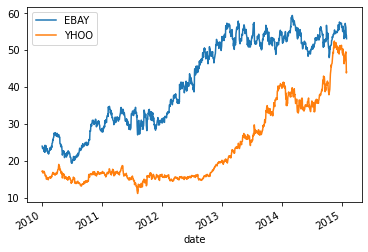

In [312]:
# Plot the raw values over time
prices.plot()
plt.show()

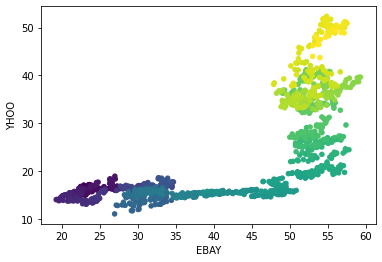

In [313]:
# Scatterplot with color relating to time
prices.plot.scatter('EBAY', 'YHOO', c=prices.index, 
                    cmap=plt.cm.viridis, colorbar=False)
plt.show()

In [315]:
all_prices = pd.read_csv('prices.csv', index_col=0)
all_prices.index = pd.to_datetime(all_prices.index)
all_prices = all_prices[all_prices.index <= '2015-01-30']
all_prices = all_prices.pivot(columns='symbol', values=['close'])
all_prices.columns = [tup[1] for tup in all_prices.columns.to_flat_index()]
all_prices.head()

,AAPL,ABT,AIG,AMAT,ARNC,BAC,BSX,C,CHK,CMCSA,...,QCOM,RF,SBUX,T,V,VZ,WFC,XOM,XRX,YHOO
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,214.009998,54.459951,29.889999,14.30,16.650013,15.690000,9.01,3.40,28.090001,16.969999,...,46.939999,5.42,23.049999,28.580000,88.139999,33.279869,27.320000,69.150002,8.63,17.100000
2010-01-05,214.379993,54.019953,29.330000,14.19,16.130013,16.200001,9.04,3.53,28.970002,16.740000,...,48.070000,5.60,23.590000,28.440001,87.129997,33.339868,28.070000,69.419998,8.64,17.230000
2010-01-06,210.969995,54.319953,29.139999,14.16,16.970013,16.389999,9.16,3.64,28.650002,16.620001,...,47.599998,5.67,23.420000,27.610001,85.959999,31.919873,28.110001,70.019997,8.56,17.170000
2010-01-07,210.580000,54.769952,28.580000,14.01,16.610014,16.930000,9.09,3.65,28.720002,16.969999,...,48.980000,6.17,23.360001,27.299999,86.760002,31.729875,29.129999,69.800003,8.60,16.700001
2010-01-08,211.980005,55.049952,29.340000,14.55,17.020014,16.780001,9.00,3.59,28.910002,16.920000,...,49.470001,6.18,23.280001,27.100000,87.000000,31.749874,28.860001,69.519997,8.57,16.700001


In [316]:
# Use stock symbols to extract training data
X = all_prices[['EBAY', 'NVDA', 'YHOO']]
y = all_prices[['AAPL']]

# Fit and score the model with cross-validation
scores = cross_val_score(Ridge(), X, y, cv=3)
print(scores)

[-6.09050633 -0.3179172  -3.72957284]


In [322]:
X = X.values
y = y.values

In [334]:
X = X[:775]
y = y[:775]

In [335]:
# Split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=.8, shuffle=False, random_state=1)

# Fit our model and generate predictions
model = Ridge()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
score = r2_score(y_test, predictions)
print(score)

-5.709399019485134


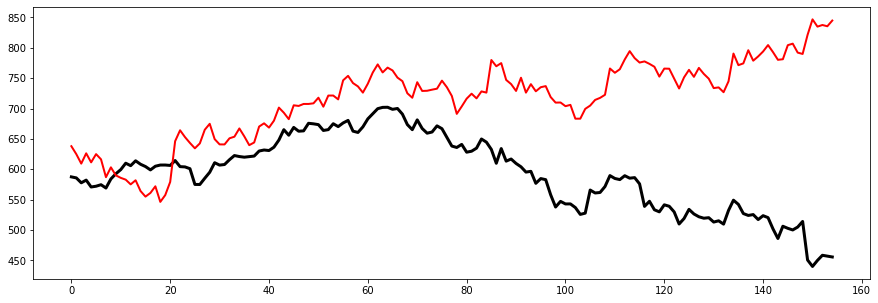

In [336]:
# Visualize our predictions along with the "true" values, and print the score
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test, color='k', lw=3)
ax.plot(predictions, color='r', lw=2)
plt.show()

## Messy Data

In [394]:
# Read in the data
prices = pd.read_csv('prices.csv', index_col=0)
prices.index = pd.to_datetime(prices.index)
prices = prices[prices.symbol.isin(['EBAY', 'NVDA', 'YHOO'])]
prices = prices[prices.index < '2016-12-31']
prices = prices.pivot(columns='symbol', values=['close'])
prices.columns = [tup[1] for tup in prices.columns.to_flat_index()]
print(prices.shape)
prices.head()

(1762, 3)


,EBAY,NVDA,YHOO
date,,,
2010-01-04,23.900000,18.490000,17.100000
2010-01-05,23.650000,18.760000,17.230000
2010-01-06,23.500000,18.879999,17.170000
2010-01-07,23.229998,18.510000,16.700001
2010-01-08,23.509999,18.549999,16.700001


In [395]:
prices.loc[(prices.EBAY.index >= '2013-01-02') & (prices.EBAY.index <= '2014-01-31'), ['EBAY']] = np.nan
prices.loc[(prices.YHOO.index >= '2011-05-02') & (prices.YHOO.index <= '2012-03-30'), ['YHOO']] = np.nan
prices.loc[(prices.NVDA.index >= '2011-01-03') & (prices.NVDA.index <= '2012-12-31'), ['NVDA']] = np.nan

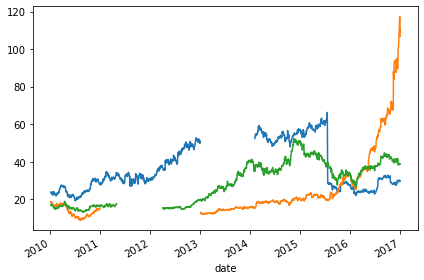

EBAY    273
NVDA    502
YHOO    232
dtype: int64


In [396]:
# Visualize the dataset
prices.plot(legend=False)
plt.tight_layout()
plt.show()

# Count the missing values of each time series
missing_values = prices.isna().sum()
print(missing_values)

In [397]:
# Create a function we'll use to interpolate and plot
def interpolate_and_plot(prices, interpolation):

    # Create a boolean mask for missing values
    missing_values = prices.isna()

    # Interpolate the missing values
    prices_interp = prices.interpolate(interpolation)

    # Plot the results, highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # Now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=False)
    plt.show()

In [398]:
prices = prices[prices.index <= '2015-01-30']
prices.shape

(1278, 3)

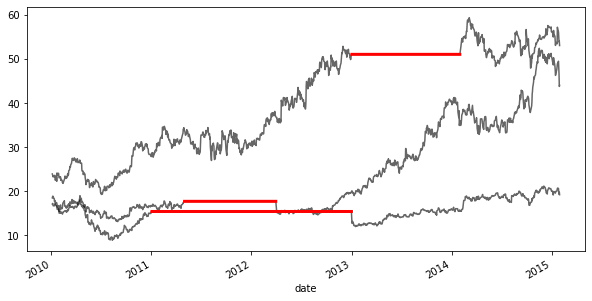

In [399]:
# Interpolate using the latest non-missing value
interpolation_type = 'zero'
interpolate_and_plot(prices, interpolation_type)

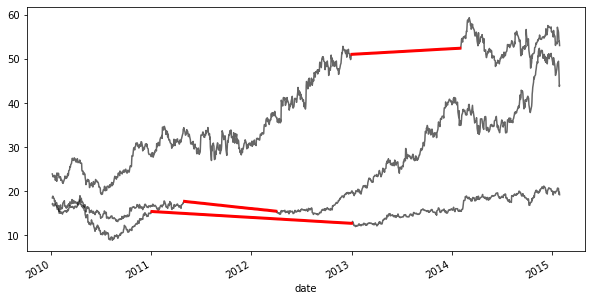

In [400]:
# Interpolate linearly
interpolation_type = 'linear'
interpolate_and_plot(prices, interpolation_type)

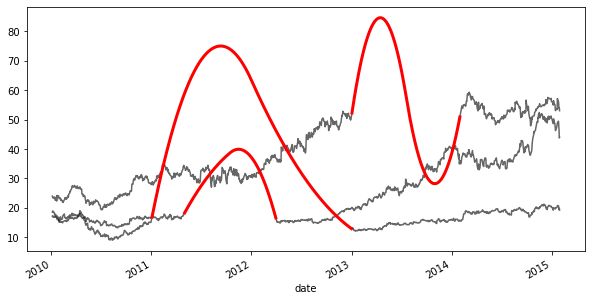

In [401]:
# Interpolate with a quadratic function
interpolation_type = 'quadratic'
interpolate_and_plot(prices, interpolation_type)

In [402]:
# Read in the data
prices = pd.read_csv('prices.csv', index_col=0)
prices.index = pd.to_datetime(prices.index)
prices = prices[prices.symbol.isin(['EBAY', 'NVDA', 'YHOO', 'AAPL'])]
prices = prices[prices.index <= '2015-01-30']
prices = prices.pivot(columns='symbol', values=['close'])
prices.columns = [tup[1] for tup in prices.columns.to_flat_index()]
print(prices.shape)
prices.head()

(1278, 4)


,AAPL,EBAY,NVDA,YHOO
date,,,,
2010-01-04,214.009998,23.900000,18.490000,17.100000
2010-01-05,214.379993,23.650000,18.760000,17.230000
2010-01-06,210.969995,23.500000,18.879999,17.170000
2010-01-07,210.580000,23.229998,18.510000,16.700001
2010-01-08,211.980005,23.509999,18.549999,16.700001


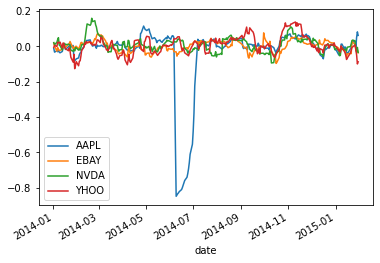

In [403]:
# Your custom function
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

# Apply your custom function and plot
prices_perc = prices.rolling(20).apply(percent_change)
prices_perc.loc["2014":"2015"].plot()
plt.show()

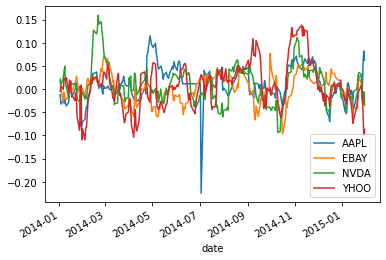

In [404]:
def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the differences that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series

# Apply your preprocessing function to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)
prices_perc.loc["2014":"2015"].plot()
plt.show()

In [405]:
prices_perc = prices_perc.EBAY

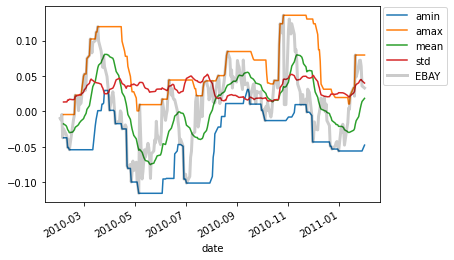

In [406]:
# Define a rolling window with Pandas, excluding the right-most datapoint of the window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')

# Define the features you'll calculate for each window
features_to_calculate = [np.min, np.max, np.mean, np.std]

# Calculate these features for your rolling window object
features = prices_perc_rolling.aggregate(features_to_calculate)

# Plot the results
ax = features.loc[:"2011-01"].plot()
prices_perc.loc[:"2011-01"].plot(ax=ax, color='k', alpha=.2, lw=3)
ax.legend(loc=(1.01, .6))
plt.show()

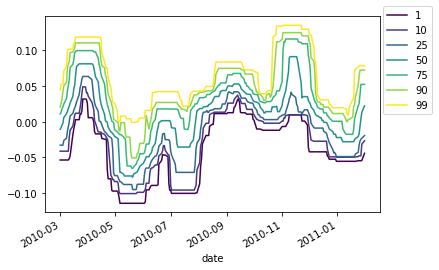

In [407]:
# Import partial from functools
percentiles = [1, 10, 25, 50, 75, 90, 99]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')
features_percentiles = prices_perc_rolling.aggregate(percentile_functions)

# Plot a subset of the result
ax = features_percentiles.loc[:"2011-01"].plot(cmap=plt.cm.viridis)
ax.legend(percentiles, loc=(1.01, .5))
plt.show()

In [408]:
prices_perc = pd.DataFrame(prices_perc)
prices_perc.index = pd.to_datetime(prices_perc.index)

In [409]:
prices_perc = prices_perc[(prices_perc.index >= '2014-01-02') & (prices_perc.index <= '2015-12-31')]
prices_perc.shape

(272, 1)

In [410]:
# Extract date features from the data, add them as columns
prices_perc['day_of_week'] = prices_perc.index.dayofweek
prices_perc['week_of_year'] = prices_perc.index.weekofyear
prices_perc['month_of_year'] = prices_perc.index.month

# Print prices_perc
print(prices_perc)

                EBAY  day_of_week  week_of_year  month_of_year
date                                                          
2014-01-02  0.017938            3             1              1
2014-01-03  0.002268            4             1              1
2014-01-06 -0.027365            0             2              1
2014-01-07 -0.006665            1             2              1
2014-01-08 -0.017206            2             2              1
...              ...          ...           ...            ...
2015-01-26  0.011183            0             5              1
2015-01-27 -0.012609            1             5              1
2015-01-28 -0.025789            2             5              1
2015-01-29 -0.020465            3             5              1
2015-01-30 -0.035902            4             5              1

[272 rows x 4 columns]


# Chapter 4 - Validating and Inspecting Time Series Models

In [412]:
prices = pd.read_csv('prices.csv', index_col=0)
prices.index = pd.to_datetime(prices.index)
prices = prices[prices.symbol.isin(['AAPL'])]
prices = prices[prices.index <= '2016-12-30']
prices = prices.pivot(columns='symbol', values=['close'])
prices.columns = [tup[1] for tup in prices.columns.to_flat_index()]
print(prices.shape)
prices.head()

(1762, 1)


,AAPL
date,
2010-01-04,214.009998
2010-01-05,214.379993
2010-01-06,210.969995
2010-01-07,210.580000
2010-01-08,211.980005


In [415]:
prices_perc = prices.rolling(20).apply(percent_change)
prices_perc = prices_perc.apply(replace_outliers)
prices_perc = prices_perc.AAPL
prices_perc.shape

(1762,)

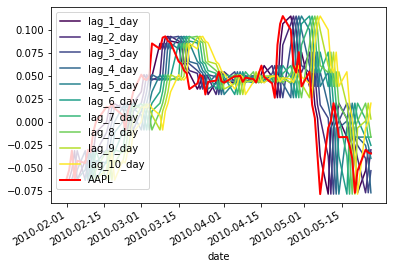

In [416]:
# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis)
prices_perc.iloc[:100].plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()

In [417]:
# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc.fillna(np.nanmedian(prices_perc))

# Fit the model
model = Ridge()
model.fit(X, y)

Ridge()

In [418]:
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')
    
    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax

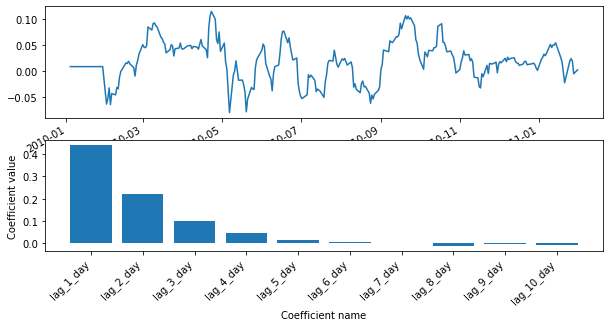

In [419]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

In [422]:
# use a much larger window (40 instead of 20). 
# As the window grows, the difference between neighboring timepoints gets smaller, resulting in a smoother signal. 
prices_perc = prices.rolling(40).apply(percent_change)
prices_perc = prices_perc.apply(replace_outliers)
prices_perc = prices_perc.AAPL
prices_perc.shape

(1762,)

In [423]:
# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

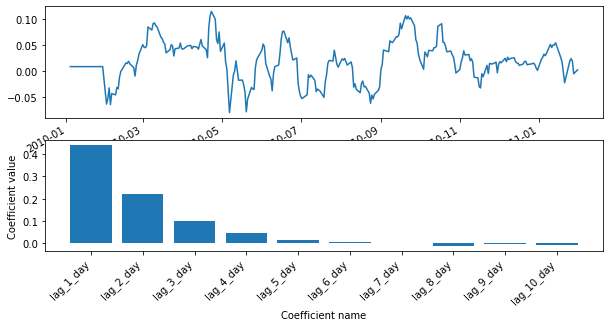

In [424]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])
plt.show()

In [439]:
X = pd.read_csv('chapter4-X.csv', index_col=0)
X = X.values
X.shape

(400, 10)

In [440]:
y = pd.read_csv('chapter4-y.csv', index_col=0)
y = y.values
y.shape

(400, 1)

In [443]:
model = LinearRegression()

In [444]:
def visualize_predictions(results):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Loop through our model results to visualize them
    for ii, (prediction, score, indices) in enumerate(results):
        # Plot the predictions of the model in the order they were generated
        offset = len(prediction) * ii
        axs[0].scatter(np.arange(len(prediction)) + offset, prediction, label='Iteration {}'.format(ii))
        
        # Plot the predictions of the model according to how time was ordered
        axs[1].scatter(indices, prediction)
    axs[0].legend(loc="best")
    axs[0].set(xlabel="Test prediction number", title="Predictions ordered by test prediction number")
    axs[1].set(xlabel="Time", title="Predictions ordered by time")
    plt.show()

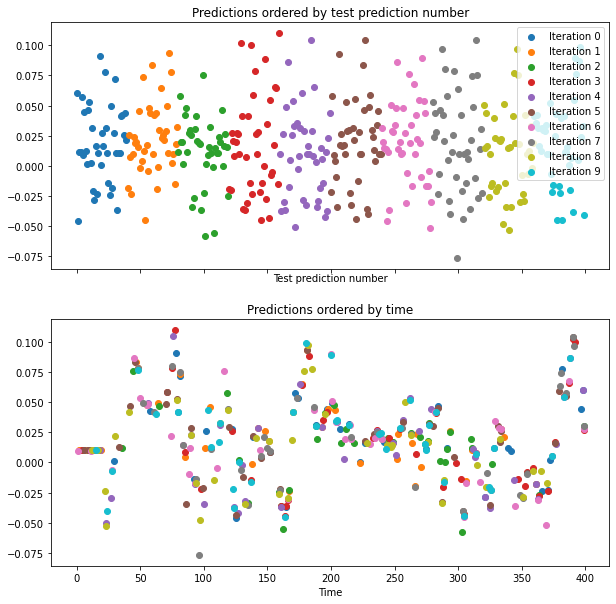

In [445]:
# Import ShuffleSplit and create the cross-validation object
cv = ShuffleSplit(n_splits=10, random_state=1)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])
    
    # Generate predictions on the test data, score the predictions, and collect
    prediction = model.predict(X[tt])
    score = r2_score(y[tt], prediction)
    results.append((prediction, score, tt))

# Custom function to quickly visualize predictions
visualize_predictions(results)

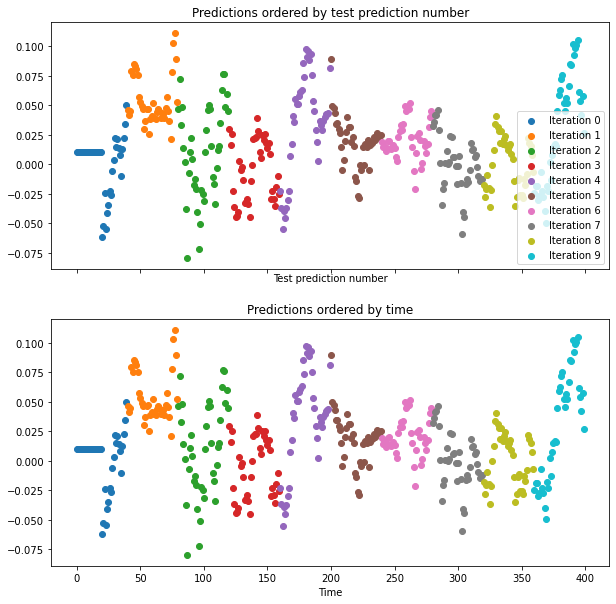

In [449]:
# Create KFold cross-validation object
cv = KFold(n_splits=10, shuffle=False)#, random_state=1)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])
    
    # Generate predictions on the test data and collect
    prediction = model.predict(X[tt])
    score = r2_score(y[tt], prediction)
    results.append((prediction, score, tt))
    
# Custom function to quickly visualize predictions
visualize_predictions(results)

This time, the predictions generated within each CV loop look 'smoother' than they were before - they look more like a real time series because you didn't shuffle the data. This is a good sanity check to make sure your CV splits are correct.

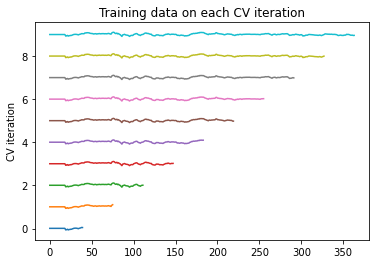

In [451]:
# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=10)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + y[tr])

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

Note that the size of the training set grew each time when you used the time series cross-validation object. This way, the time points you predict are always after the timepoints we train on.

In [453]:
def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 2-D dataset."""
    # Create empty array to fill the results
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)

    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

In [454]:
X = pd.read_csv('chapter4-X2.csv', index_col=0)
X = X.values
X.shape

(1762, 12)

In [455]:
y = pd.read_csv('chapter4-y2.csv', index_col=0)
y = y.values
y.shape

(1762, 1)

In [456]:
# Iterate through CV splits
n_splits = 100
cv = TimeSeriesSplit(n_splits=n_splits)

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits, X.shape[1]])

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
    model.fit(X[tr], y[tr])
    coefficients[ii] = model.coef_

In [458]:
feature_names = ['AAPL_lag_1_day', 'YHOO_lag_1_day', 'NVDA_lag_1_day', 'AAPL_lag_2_day',
       'YHOO_lag_2_day', 'NVDA_lag_2_day', 'AAPL_lag_3_day', 'YHOO_lag_3_day',
       'NVDA_lag_3_day', 'AAPL_lag_4_day', 'YHOO_lag_4_day', 'NVDA_lag_4_day']

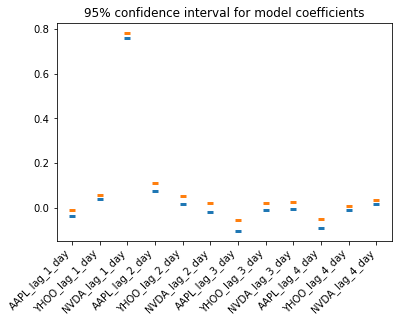

In [459]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients)

# Plot it
fig, ax = plt.subplots()
ax.scatter(feature_names, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(feature_names, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

You've calculated the variability around each coefficient, which helps assess which coefficients are more stable over time!

In [460]:
cv = TimeSeriesSplit(max_train_size=None, n_splits=100)

In [462]:
def my_pearsonr(est, X, y):
    return np.corrcoef(est.predict(X).squeeze(), y.squeeze())[1, 0]

In [464]:
tscores = ['2010-04-05', '2010-04-28', '2010-05-21', '2010-06-16',
               '2010-07-12', '2010-08-04', '2010-08-27', '2010-09-22',
               '2010-10-15', '2010-11-09', '2010-12-03', '2010-12-29',
               '2011-01-24', '2011-02-16', '2011-03-14', '2011-04-06',
               '2011-05-02', '2011-05-25', '2011-06-20', '2011-07-14',
               '2011-08-08', '2011-08-31', '2011-09-26', '2011-10-19',
               '2011-11-11', '2011-12-07', '2012-01-03', '2012-01-27',
               '2012-02-22', '2012-03-16', '2012-04-11', '2012-05-04',
               '2012-05-30', '2012-06-22', '2012-07-18', '2012-08-10',
               '2012-09-05', '2012-09-28', '2012-10-23', '2012-11-19',
               '2012-12-13', '2013-01-09', '2013-02-04', '2013-02-28',
               '2013-03-25', '2013-04-18', '2013-05-13', '2013-06-06',
               '2013-07-01', '2013-07-25', '2013-08-19', '2013-09-12',
               '2013-10-07', '2013-10-30', '2013-11-22', '2013-12-18',
               '2014-01-14', '2014-02-07', '2014-03-05', '2014-03-28',
               '2014-04-23', '2014-05-16', '2014-06-11', '2014-07-07',
               '2014-07-30', '2014-08-22', '2014-09-17', '2014-10-10',
               '2014-11-04', '2014-11-28', '2014-12-23', '2015-01-20',
               '2015-02-12', '2015-03-10', '2015-04-02', '2015-04-28',
               '2015-05-21', '2015-06-16', '2015-07-10', '2015-08-04',
               '2015-08-27', '2015-09-22', '2015-10-15', '2015-11-09',
               '2015-12-03', '2015-12-29', '2016-01-25', '2016-02-18',
               '2016-03-14', '2016-04-07', '2016-05-02', '2016-05-25',
               '2016-06-20', '2016-07-14', '2016-08-08', '2016-08-31',
               '2016-09-26', '2016-10-19', '2016-11-11', '2016-12-07']

In [468]:
times_scores = pd.DatetimeIndex(data=tscores)

In [472]:
times_scores.shape

(100,)

In [476]:
type(scores_series)

pandas.core.series.Series

In [474]:
# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)

# Convert to a Pandas Series object
scores_series = pd.Series(scores, index=times_scores, name='score')

# Bootstrap a rolling confidence interval for the mean score
scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))

TypeError: only size-1 arrays can be converted to Python scalars

NameError: name 'scores_lo' is not defined

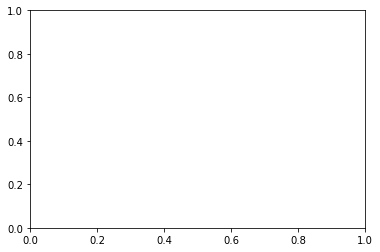

In [477]:
# Plot the results
fig, ax = plt.subplots()
scores_lo.plot(ax=ax, label="Lower confidence interval")
scores_hi.plot(ax=ax, label="Upper confidence interval")
ax.legend()
plt.show()

In [478]:
model = LinearRegression()

In [479]:
cv = TimeSeriesSplit(max_train_size=100, n_splits=100)

In [480]:
# Pre-initialize window sizes
window_sizes = [25, 50, 75, 100]

# Create an empty DataFrame to collect the stores
all_scores = pd.DataFrame(index=times_scores)

# Generate scores for each split to see how the model performs over time
for window in window_sizes:
    # Create cross-validation object using a limited lookback window
    cv = TimeSeriesSplit(n_splits=100, max_train_size=window)
    
    # Calculate scores across all CV splits and collect them in a DataFrame
    this_scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
    all_scores['Length {}'.format(window)] = this_scores

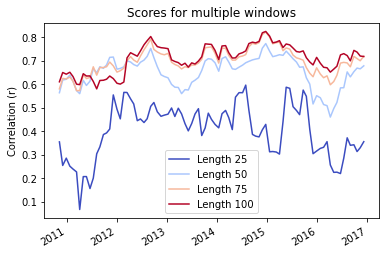

In [481]:
# Visualize the scores
ax = all_scores.rolling(10).mean().plot(cmap=plt.cm.coolwarm)
ax.set(title='Scores for multiple windows', ylabel='Correlation (r)')
plt.show()